# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2024-2025 exercise 2


Authors: [Hannu Parviainen](mailto:hannu@iac.es), [Fynn Dobrindt](mailto:alu0101768366@ull.edu.es)<br>
Last updated: 30.04.2025

## Initialisation

In [1]:
%matplotlib inline 

In [22]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner
from astropy import units as u


from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

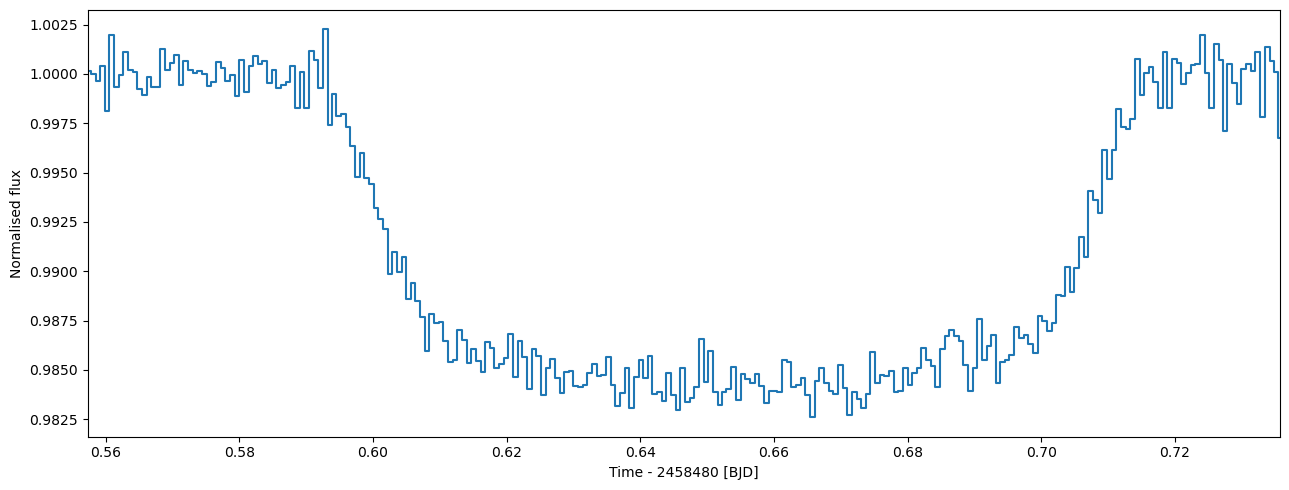

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()
fig

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [6]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [8]:
lpf.optimize_global(niter=500, npop=50)

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

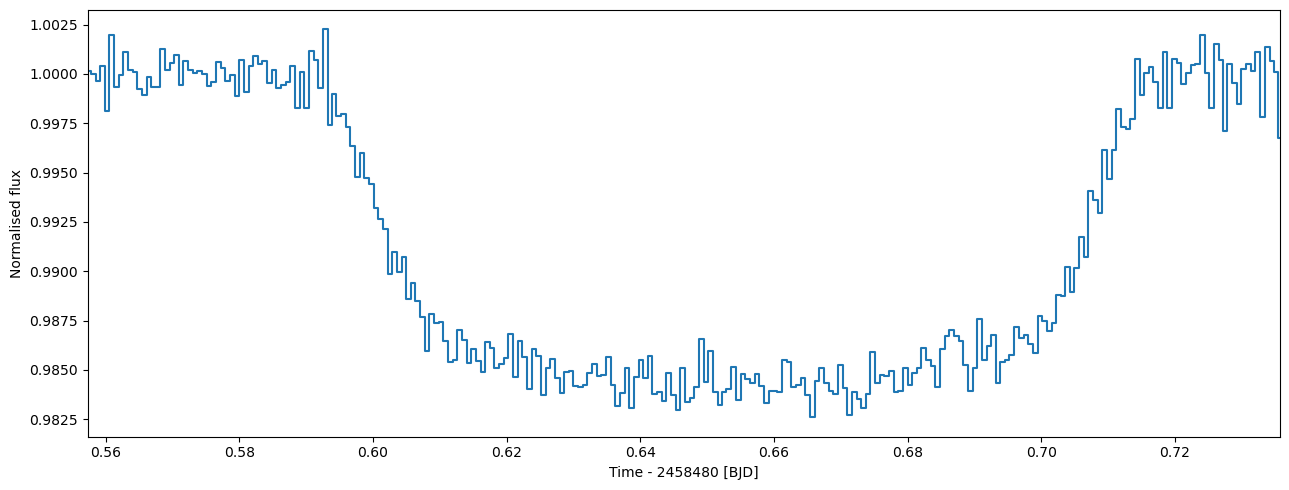

In [9]:
lpf.plot_light_curve()
fig

In [10]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

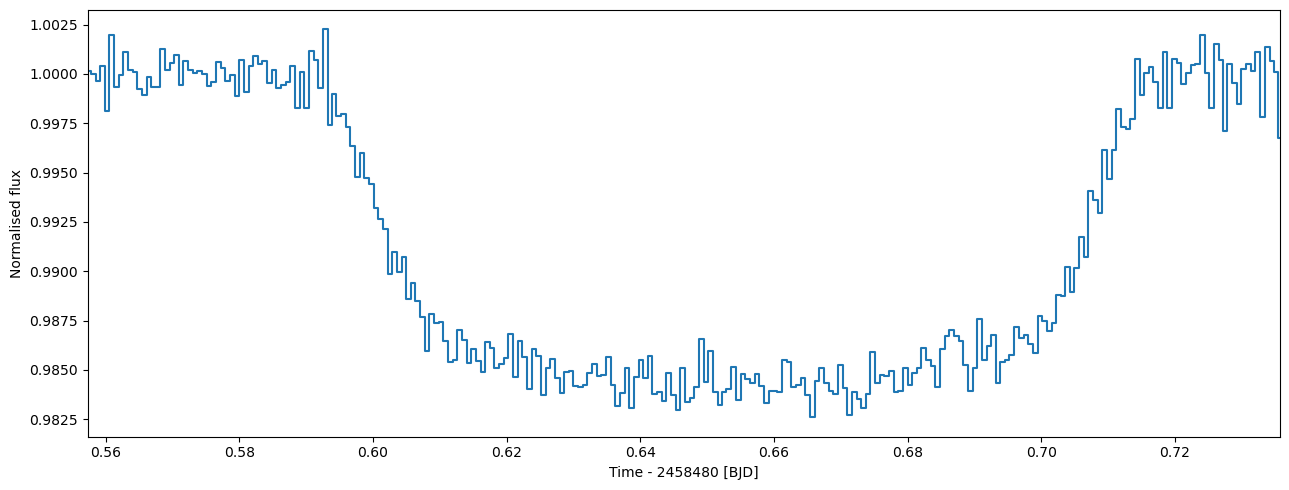

In [11]:
lpf.plot_light_curve('mc')
fig

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

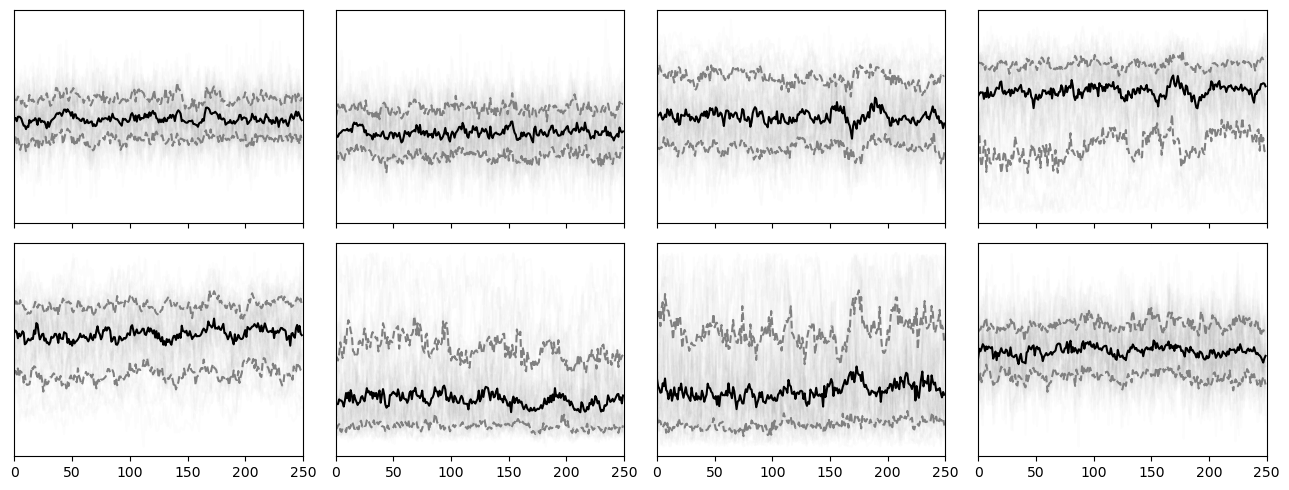

In [12]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()
fig

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [13]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [14]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

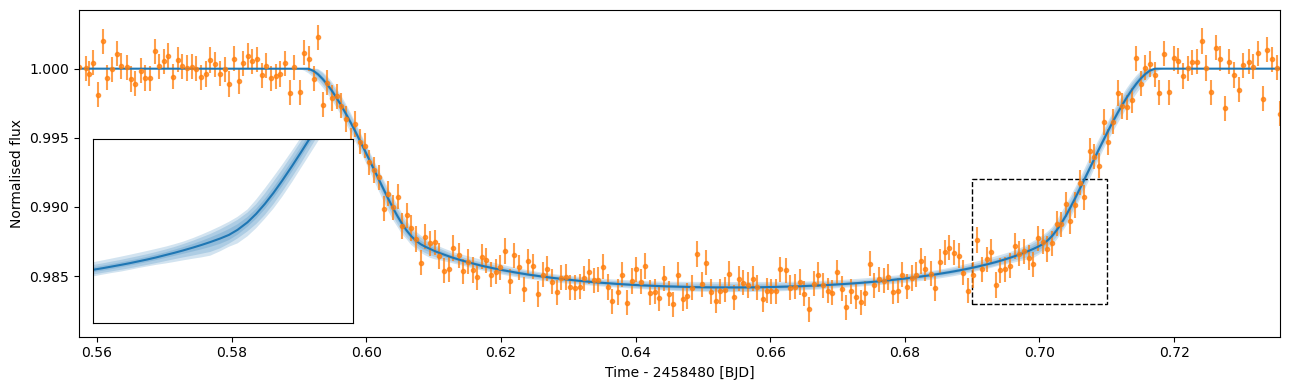

In [15]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()


az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0')
fig

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [16]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4345,0.3361,0.0140,0.3221,0.3461,-3.0399,0.1181,3.0108,1.4577,0.1258,0.0946
std,1.6309e-04,1.1000e-09,0.0370,0.1223,0.0005,0.2062,0.2433,0.0194,0.0020,0.0855,0.0434,0.0010,0.0027
min,2.4585e+06,1.0914e+00,0.3238,0.0004,0.0125,0.0323,0.0001,-3.1088,0.1116,2.7321,1.3567,0.1223,0.0866
25%,2.4585e+06,1.0914e+00,0.4068,0.2667,0.0136,0.1621,0.1530,-3.0532,0.1167,2.9478,1.4254,0.1251,0.0926
50%,2.4585e+06,1.0914e+00,0.4318,0.3671,0.0140,0.2652,0.2858,-3.0402,0.1184,3.0070,1.4483,0.1258,0.0944
75%,2.4585e+06,1.0914e+00,0.4626,0.4277,0.0143,0.4302,0.4970,-3.0268,0.1196,3.0769,1.4841,0.1264,0.0967
max,2.4585e+06,1.0914e+00,0.5395,0.5804,0.0151,0.9999,1.0000,-2.9697,0.1230,3.2387,1.5707,0.1301,0.1017


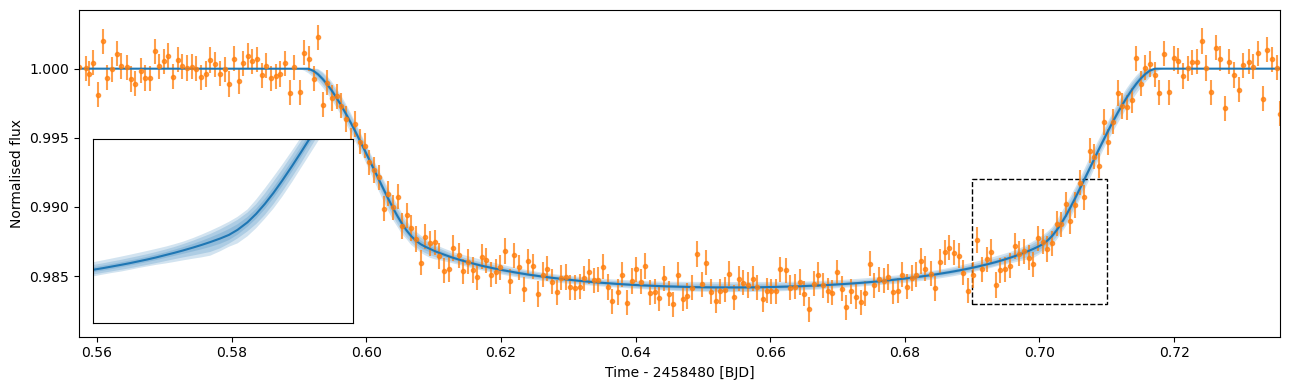

In [17]:
df.tc.hist(bins=50)
fig

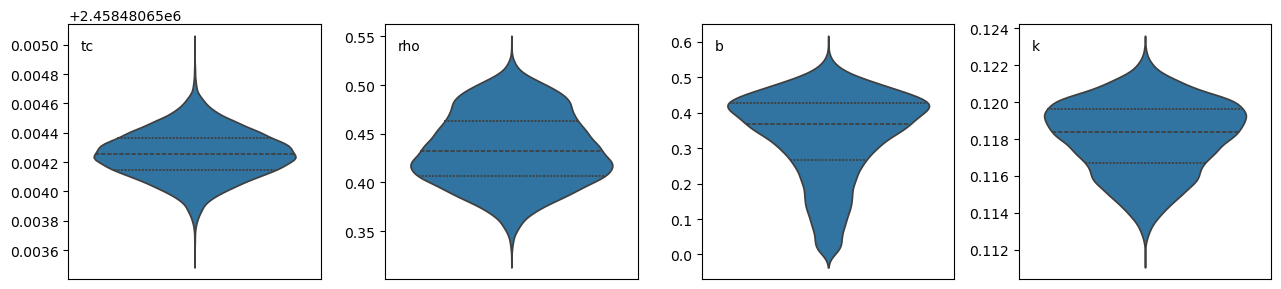

In [18]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()
fig

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

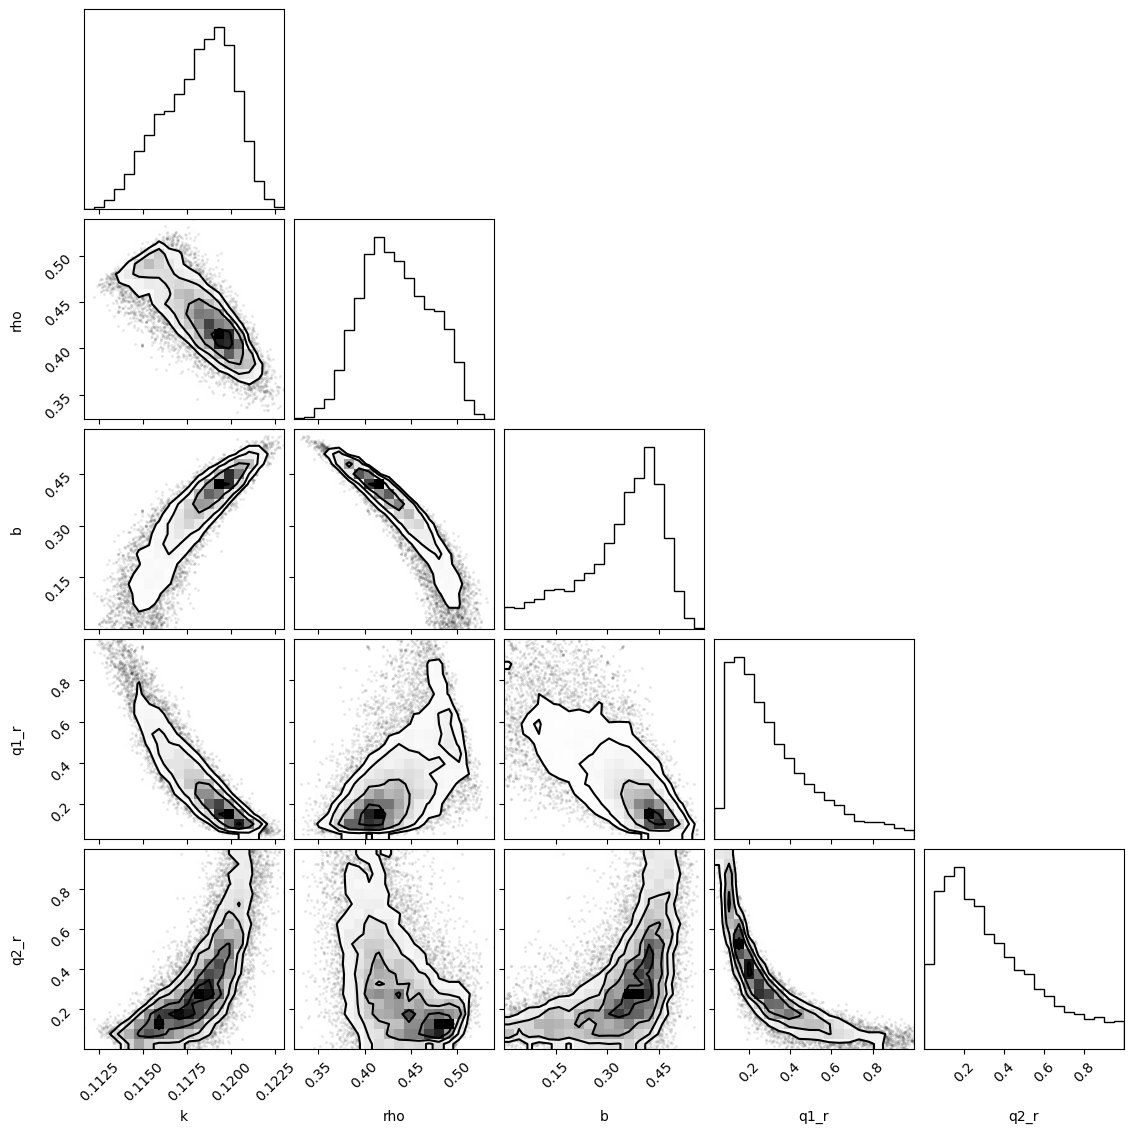

In [19]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols].values, labels=ccols)

### <span style="color:lightblue">Questions and exercises</span>

> 1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere) Give the answer in Jupiter radii.

With $k = R_p/R_\star$ and $R_\star = 1.657 \,R_\odot$ [[Collins et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/153/2/78#back-to-top-target)], we obtain:

In [20]:
R_p = np.array(df.k)*1.657 * u.R_sun
print("R_p =", R_p.mean().value, "+/-", R_p.std())

R_p = 0.19571379810434958 +/- 0.003250779928550004 solRad


Which results in $$R_p \approx (0.196 \pm 0.003) \, \text{R}_\odot.$$

> 2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.



First we plot the density from our model:

In [21]:
rho = np.array(df.rho) * u.g / u.cm**3
print("rho =", rho.mean().value, "+/-", rho.std())

rho = 0.4344723099924739 +/- 0.03695013539728365 g / cm3


The obtained value $$\rho_\star = 0.44 \pm 0.04 \, \text{g cm}^{-3}$$ is in good agreement with the theoretical value [[Collins et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/153/2/78#back-to-top-target)] of $$\rho_{\star\text{,lit}} = 0.446 \pm 0.012 \, \text{g cm}^{-3}.$$ 



> 3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?



The correlation between the parameters means that the posterior distributions of the parameters are not independent. This can lead to difficulties in estimating the uncertainties of the parameters, as well as in interpreting the results. For example, if two parameters are highly correlated, it may be difficult to determine which parameter is responsible for a particular feature in the data. In addition, if one parameter is poorly constrained, it can affect the estimates of other correlated parameters.

The correlation between the limb darkening coefficients for example means that they cannot be estimated independently, and that the uncertainties in one coefficient will affect the uncertainties in the other. This is important to keep in mind when interpreting the results of the analysis, as it can lead to over- or under-estimation of the uncertainties in the parameters.



---
<center>&copy;2025 Hannu Parviainen</center>